<a href="https://colab.research.google.com/github/lizliu2015/Using-classification-to-predict-customer-value/blob/master/Using_classification_to_predict_customer_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using classification to predict customer value

I picked Black Friday dataset on kaggle and did the following things:

1.Apply LogisticRegression, SVM, RandomForest classification algorithms, and compare the model performance

2.Apply GridSearchCV to find the best hyperparameters for my models

3.Assess model performance (confusion matrix, precision, recall, ROC AUC) 

4.Apply AutoML (Auto sklearn) to build classification model and compare model performance.


#Ingestion

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#loading kaggle API
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#!kaggle datasets list

Saving kaggle.json to kaggle (3).json


In [0]:
#load kaggle dataset
!kaggle datasets download -d mehdidag/black-friday

black-friday.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#unzip file
!unzip black-friday.zip -d /dev/shm 

Archive:  black-friday.zip
replace /dev/shm/BlackFriday.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /dev/shm/BlackFriday.csv  


In [0]:
#read file
df = pd.read_csv('/dev/shm/BlackFriday.csv')

# Data cleaning

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [0]:
#checking for missing value
print('<Contain NaNs?>')
print(df.isnull().any())
missing_ser_percentage = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
missing_ser_percentage = missing_ser_percentage[missing_ser_percentage!=0].round(2)
missing_ser_percentage.name = 'missing values %'
print('\n<NaN ratio>')
print(missing_ser_percentage)

<Contain NaNs?>
User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool

<NaN ratio>
Product_Category_3    69.44
Product_Category_2    31.06
Name: missing values %, dtype: float64


In [0]:
#filling missing values
df.fillna(0,inplace=True)
print(df.isnull().sum())

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc9f7bf0f0>,
      dtype=object)

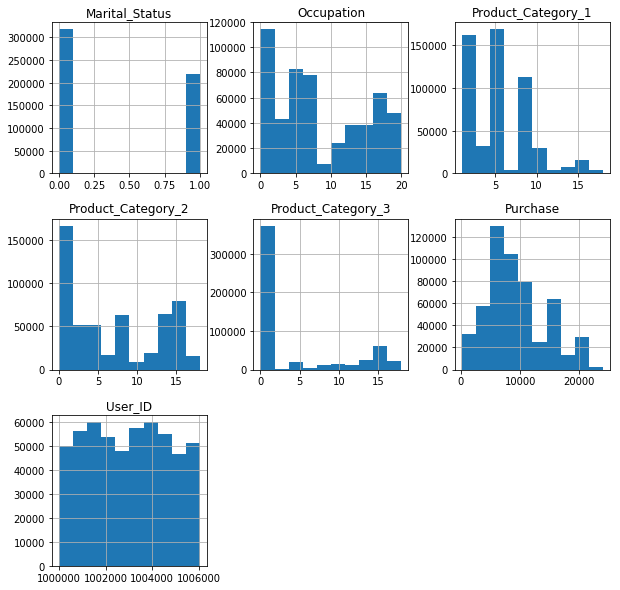

In [0]:
df.hist(figsize = (10,10))

#EDA

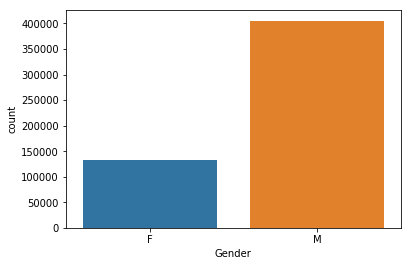

In [0]:
sns.countplot(df['Gender'])

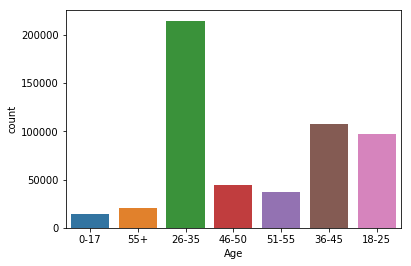

In [0]:
sns.countplot(df['Age'])

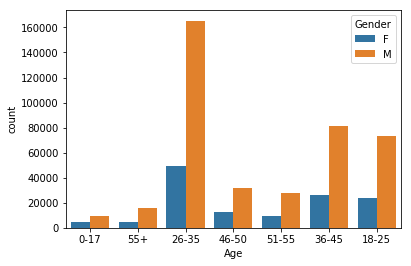

In [0]:
sns.countplot(df['Age'],hue=df['Gender'])

# Modeling

##Feature engineering

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [0]:
le_U_ID = LabelEncoder()
df['User_ID'] = le_U_ID.fit_transform(df['User_ID'])
le_P_ID = LabelEncoder()
df['Product_ID'] = le_P_ID.fit_transform(df['Product_ID'])
df['Gender'] = np.where(df['Gender']=='M',1,0) # Female: 0, Male: 1
df_Age = pd.get_dummies(df.Age)
df_CC = pd.get_dummies(df.City_Category)
df_SIC = pd.get_dummies(df.Stay_In_Current_City_Years)
df_encoded = pd.concat([df,df_Age,df_CC,df_SIC],axis=1)
df_encoded.drop(['Age','City_Category','Stay_In_Current_City_Years'],axis=1,inplace=True)

In [0]:
bins = [0, 10000, 20000, 30000]
labels = ["bronze","silver","gold"]
df['Purchase'] = pd.cut(df['Purchase'], bins=bins, labels=labels)

In [0]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,670,0,0-17,10,A,2,0,3,0.0,0.0,bronze
1,0,2374,0,0-17,10,A,2,0,1,6.0,14.0,silver
2,0,850,0,0-17,10,A,2,0,12,0.0,0.0,bronze
3,0,826,0,0-17,10,A,2,0,12,14.0,0.0,bronze
4,1,2732,1,55+,16,C,4+,0,8,0.0,0.0,bronze


 Heatmap

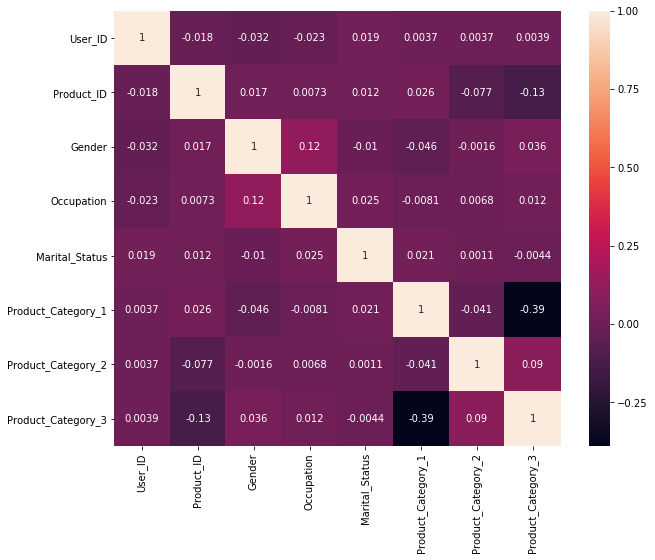

In [0]:
plt.figure(figsize=(10,8)) 
sns.heatmap(df.corr(), annot=True)

## Model preparation 

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_fit = pd.DataFrame(sc.fit_transform(df_encoded.drop(['User_ID','Product_ID','Purchase'],axis=1)))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Apply different models(LogisticRegression, RandomForest, SVC)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X = X_fit
# df.reset_index()
y = df_encoded['Purchase']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(430061, 21) (430061,)
(107516, 21) (107516,)


###Logistic Regression

In [0]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

lm = linear_model.LogisticRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

model.score(X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7857342163026898

In [0]:
#cross validation
from sklearn.model_selection import cross_val_score, cross_val_predict
scores = cross_val_score(model, X, y, cv=6)
print("Cross-validated scores:", scores)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Cross-validated scores: [0.78540576 0.78516022 0.78678974 0.78707992 0.78507729 0.78432708]


###Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier()
rfr.fit(X_train,y_train)
print('The accuracy of the Random Forest is',rfr.score(X_test,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The accuracy of the Random Forest is 0.8567189999627962


###SVC

In [0]:
from sklearn import svm
svc=svm.SVC(gamma='auto_deprecated')
svc.fit(X_train,y_train)
prediction_svc=svc.predict(X_test)
print('The accuracy of the SVC is', svc.score(X_test,y_test))

##Using GridSearchCV to optimize the paramaters

In [0]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [100,200, 300, 400],'max_depth' :[2,3,4,5]}
RF = RandomForestRegressor()

clf_RF = GridSearchCV(RF, parameters, cv=5)
clf_RF.fit(X_train,y_train)

In [0]:
clf_RF.best_params_

{'max_depth': 5, 'n_estimators': 400}

In [0]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=400, max_depth=5)
RF.fit(X_train,y_train)
prediction_RF=RF.predict(X_test)
print('The accuracy of the Random Forest Regression is',metrics.accuracy_score(prediction_RF,y_test))

The accuracy of the Random Forest Regression is 0.7922077922077922


In [0]:
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.1, 1, 10,100]}
SVC = svm.SVC(kernel='rbf')

clf_SVC = GridSearchCV(SVC, parameters, cv=5)
clf_SVC.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [0]:
clf_SVC.best_params_

{'C': 1}

In [0]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
SVC=svm.SVC(C = 1, kernel='rbf')
SVC.fit(X_train,y_train)
prediction_SVC=SVC.predict(X_test)
print('The accuracy of the SVC is',metrics.accuracy_score(prediction_SVC,y_test))

The accuracy of the SVC is 0.8181818181818182


### Model Performance

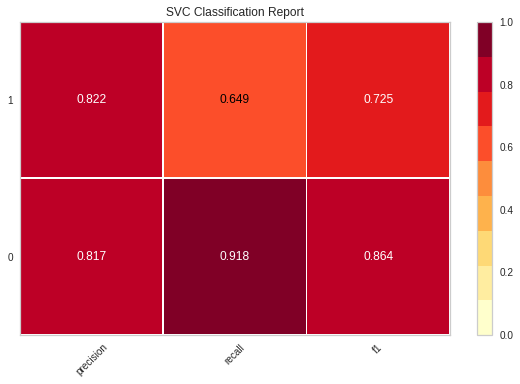

In [0]:
from yellowbrick.classifier import ClassificationReport
viz = ClassificationReport(SVC)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

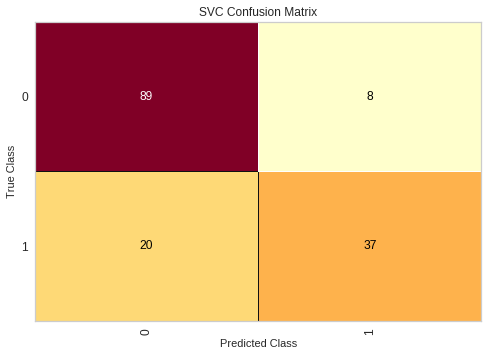

In [0]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(SVC)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

* False Positive：
 
 - Customer does not belong to this tier, but we predict that they are and will spend more on purchase
 
 
 * False Negatives: 
 
  - Customer does belong to this tier, but we predict that they are not and will not spend more on purchase
  
 In our business case, we want to lower false negative, because this type of error leads to more potential loss on revenue

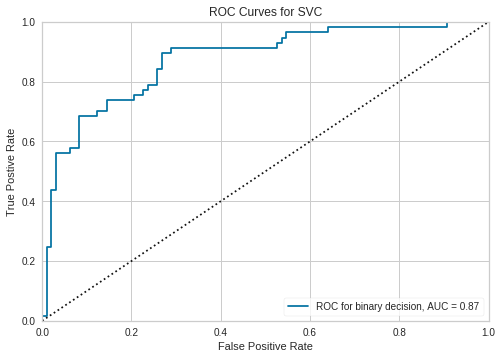

In [0]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(SVC, micro=False, macro=False, per_class=False)
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)
visualizer.poof()             

## AutoML using H2O

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! pip install h2o

     |████████████████████████████████| 121.0MB 164kB/s 
  Stored in directory: /root/.cache/pip/wheels/e9/92/d1/61cddd17defd8ba2a10400d2b3adf917377769610d904c279d
Successfully built h2o


In [0]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment (build 11.0.2+9-Ubuntu-3ubuntu118.04.3); OpenJDK 64-Bit Server VM (build 11.0.2+9-Ubuntu-3ubuntu118.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0u7ilk3v
  JVM stdout: /tmp/tmp0u7ilk3v/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0u7ilk3v/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_unknownUser_x5imzb
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
df_automl = df

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
train, test = df_automl.split_frame(ratios=[0.8], seed=7)
response = "Outcome"
train[response] = train[response].asfactor()
test[response] = test[response].asfactor()
print("Number of rows in train and test set : ", train.shape[0], test.shape[0])

Number of rows in train and test set :  610 158


In [0]:
x = df_automl.columns[:-1]
y = "Outcome"

In [0]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame = train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20190503_171812,0.828774,0.492089,0.230774,0.404251,0.163419
XGBoost_grid_1_AutoML_20190503_171812_model_4,0.827101,0.482268,0.226131,0.401333,0.161068
StackedEnsemble_AllModels_AutoML_20190503_171812,0.825821,0.49496,0.23119,0.405857,0.16472
GLM_grid_1_AutoML_20190503_171812_model_1,0.82578,0.486877,0.248452,0.401632,0.161308
XGBoost_3_AutoML_20190503_171812,0.820786,0.49318,0.239107,0.405066,0.164079
XGBoost_1_AutoML_20190503_171812,0.820494,0.489687,0.237083,0.405079,0.164089
XGBoost_2_AutoML_20190503_171812,0.81769,0.503274,0.237262,0.409271,0.167503
DeepLearning_grid_1_AutoML_20190503_171812_model_2,0.817006,0.518186,0.249405,0.412744,0.170357
XGBoost_grid_1_AutoML_20190503_171812_model_3,0.815911,0.500522,0.247202,0.408575,0.166934
GBM_5_AutoML_20190503_171812,0.809911,0.504261,0.254881,0.410761,0.168725


In [0]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190503_171812
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.10729862067936295
RMSE: 0.32756468167273917
LogLoss: 0.3561281329068389
Null degrees of freedom: 609
Residual degrees of freedom: 606
Null deviance: 785.4631271564521
Residual deviance: 434.47632214634353
AIC: 442.47632214634353
AUC: 0.9330178571428571
pr_auc: 0.8674859629647829
Gini: 0.8660357142857142
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45807797312619186: 


,0,1,Error,Rate
0,361.0,39.0,0.0975,(39.0/400.0)
1,44.0,166.0,0.2095,(44.0/210.0)
Total,405.0,205.0,0.1361,(83.0/610.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4580780,0.8000000,159.0
max f2,0.2039962,0.8755365,252.0
max f0point5,0.5623687,0.8250620,114.0
max accuracy,0.4829602,0.8639344,147.0
max precision,0.9091125,1.0,0.0
max recall,0.1058205,1.0,345.0
max specificity,0.9091125,1.0,0.0
max absolute_mcc,0.4580780,0.6970333,159.0
max min_per_class_accuracy,0.3594481,0.8476190,181.0
max mean_per_class_accuracy,0.3212376,0.8542262,196.0


Gains/Lift Table: Avg response rate: 34.43 %, avg score: 34.99 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0114754,0.8953797,2.9047619,2.9047619,1.0,0.9023303,1.0,0.9023303,0.0333333,0.0333333,190.4761905,190.4761905
,2,0.0213115,0.8837748,2.9047619,2.9047619,1.0,0.8882731,1.0,0.8958423,0.0285714,0.0619048,190.4761905,190.4761905
,3,0.0311475,0.8771911,2.9047619,2.9047619,1.0,0.8804935,1.0,0.8909953,0.0285714,0.0904762,190.4761905,190.4761905
,4,0.0409836,0.8687250,2.9047619,2.9047619,1.0,0.8724929,1.0,0.8865548,0.0285714,0.1190476,190.4761905,190.4761905
,5,0.0508197,0.8622891,2.4206349,2.8110599,0.8333333,0.8651246,0.9677419,0.8824070,0.0238095,0.1428571,142.0634921,181.1059908
,6,0.1,0.8235489,2.8079365,2.8095238,0.9666667,0.8442701,0.9672131,0.8636511,0.1380952,0.2809524,180.7936508,180.9523810
,7,0.1508197,0.7562962,2.6236559,2.7468944,0.9032258,0.7950791,0.9456522,0.8405453,0.1333333,0.4142857,162.3655914,174.6894410
,8,0.2,0.6493943,2.1301587,2.5952381,0.7333333,0.7068522,0.8934426,0.8076700,0.1047619,0.5190476,113.0158730,159.5238095
,9,0.3,0.4883600,2.0952381,2.4285714,0.7213115,0.5594857,0.8360656,0.7249419,0.2095238,0.7285714,109.5238095,142.8571429
,10,0.4,0.3364063,1.2857143,2.1428571,0.4426230,0.4246035,0.7377049,0.6498573,0.1285714,0.8571429,28.5714286,114.2857143




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.16341894668726312
RMSE: 0.40425109361294637
LogLoss: 0.49208923191420917
Null degrees of freedom: 609
Residual degrees of freedom: 606
Null deviance: 789.2199730521723
Residual deviance: 600.3488629353353
AIC: 608.3488629353353
AUC: 0.8287738095238094
pr_auc: 0.6613505255739248
Gini: 0.6575476190476188
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20591170095782885: 


,0,1,Error,Rate
0,263.0,137.0,0.3425,(137.0/400.0)
1,25.0,185.0,0.119,(25.0/210.0)
Total,288.0,322.0,0.2656,(162.0/610.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2059117,0.6954887,266.0
max f2,0.1389098,0.8087649,319.0
max f0point5,0.6588739,0.6484150,102.0
max accuracy,0.4017379,0.7557377,183.0
max precision,0.7297870,0.8111111,76.0
max recall,0.0842281,1.0,381.0
max specificity,0.9082364,0.9975,0.0
max absolute_mcc,0.2059117,0.5124633,266.0
max min_per_class_accuracy,0.3126066,0.755,217.0
max mean_per_class_accuracy,0.2059117,0.7692262,266.0


Gains/Lift Table: Avg response rate: 34.43 %, avg score: 34.47 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0114754,0.8896732,1.2448980,1.2448980,0.4285714,0.8994306,0.4285714,0.8994306,0.0142857,0.0142857,24.4897959,24.4897959
,2,0.0213115,0.8714467,2.9047619,2.0109890,1.0,0.8797197,0.6923077,0.8903333,0.0285714,0.0428571,190.4761905,101.0989011
,3,0.0311475,0.8567915,2.4206349,2.1403509,0.8333333,0.8639579,0.7368421,0.8820042,0.0238095,0.0666667,142.0634921,114.0350877
,4,0.0409836,0.8471525,1.9365079,2.0914286,0.6666667,0.8528464,0.72,0.8750063,0.0190476,0.0857143,93.6507937,109.1428571
,5,0.0508197,0.8397589,2.4206349,2.1551459,0.8333333,0.8431156,0.7419355,0.8688339,0.0238095,0.1095238,142.0634921,115.5145929
,6,0.1,0.7918076,2.4206349,2.2857143,0.8333333,0.8175604,0.7868852,0.8436175,0.1190476,0.2285714,142.0634921,128.5714286
,7,0.1508197,0.7278791,2.4362519,2.3364389,0.8387097,0.7576250,0.8043478,0.8146417,0.1238095,0.3523810,143.6251920,133.6438923
,8,0.2,0.6488677,1.5492063,2.1428571,0.5333333,0.6926848,0.7377049,0.7846523,0.0761905,0.4285714,54.9206349,114.2857143
,9,0.3,0.4639904,1.2857143,1.8571429,0.4426230,0.5510734,0.6393443,0.7067927,0.1285714,0.5571429,28.5714286,85.7142857
,10,0.4,0.3356161,1.6666667,1.8095238,0.5737705,0.4059474,0.6229508,0.6315814,0.1666667,0.7238095,66.6666667,80.9523810


In [0]:
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly
preds = aml.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%
